# Using TensorBoard with PyTorch
## Before You Start

To run this tutorial, you'll need to install PyTorch, TorchVision, Matplotlib, and TensorBoard.

With `conda`:

`conda install pytorch torchvision -c pytorch`
`conda install matplotlib tensorboard`

With `pip`:

`pip install torch torchvision matplotlib tensorboard`

Once the dependencies are installed, restart this notebook in the Python environment where you installed them.

## Introduction

In this notebook, we'll be training a variant of LeNet-5 against the Fashion-MNIST dataset. Fashion-MNIST is a set of image tiles depicting various garments, with ten class labels indicating the type of garment depicted.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


## Showing Images in TensorBoard

Let's start by adding sample images from our dataset to TensorBoard:

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

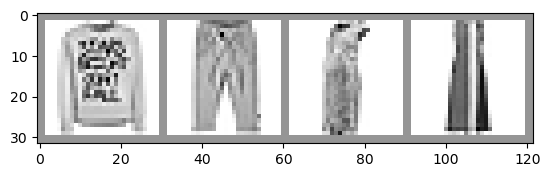

In [4]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data. Below, we use the `add_image()` call on `SummaryWriter` to log the image for consumption by TensorBoard, and we also call `flush()` to make sure it's written to disk right away.

In [5]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at [localhost:6006](localhost:6006)), you should see the image grid under the IMAGES tab.

## Graphing Scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

Let's define a model to categorize our image tiles, and an optimizer and loss function for training: